Импорт библиотек и загрузка данных

In [37]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

df = pd.read_csv("../dataset.csv")
print(df.shape[0])

2772


Удаление выбросов и проверка на пустые значения(их нет)

In [38]:
print("было ", df.shape[0])
for column in df.select_dtypes(include=['int', 'float']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()
    print(column, mean, std_dev)
    
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    
    df = df[(df[column] <= upper_bound) & (df[column] >= lower_bound)]
    
print("стало ", df.shape[0])
df = df.reset_index(drop=True)

print(df.isnull().sum())

было  2772
age 39.10966810966811 14.081459420836477
bmi 30.70134920634921 6.1294486949652205
children 1.1026753434562546 1.2157555494600176
charges 13325.498588795157 12200.175109274192
стало  2710
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Выбор выходных и выходной переменной.
Мне кажется, что возраст и индекс массы тела будут наиболее сильно влиять на цену страховки

In [39]:
print('min age: ', df['age'].min(), '|min bmi: ', df['bmi'].min(), '|min charges: ', df['charges'].min())
print('max age: ', df['age'].max(), '|max bmi: ', df['bmi'].max(), '|max charges: ', df['charges'].max())

age = np.arange(df['age'].min(), df['age'].max() + 1e-9, 1)
bmi = np.arange(df['bmi'].min(), df['bmi'].max() + 1e-9, 0.001)
charges = np.arange(df['charges'].min(), df['charges'].max() + 1e-9, 0.01)

age_ctrl = ctrl.Antecedent(age, 'age')
bmi_ctrl = ctrl.Antecedent(bmi, 'bmi')
charges_ctrl = ctrl.Consequent(charges, 'charges')

min age:  18 |min bmi:  15.96 |min charges:  1121.8739
max age:  64 |max bmi:  49.06 |max charges:  49577.6624


Настройка параметров лигвистических переменных

11801.75692885742


c:\ulstu\3.1\mii\AIM-PIbd-31-Barsukov-P-O\aimenv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\ulstu\3.1\mii\AIM-PIbd-31-Barsukov-P-O\aimenv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


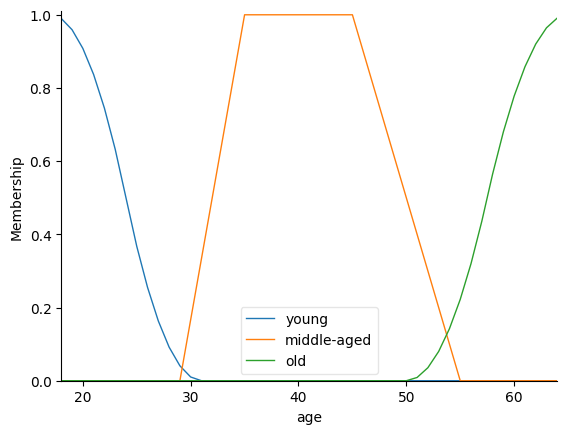

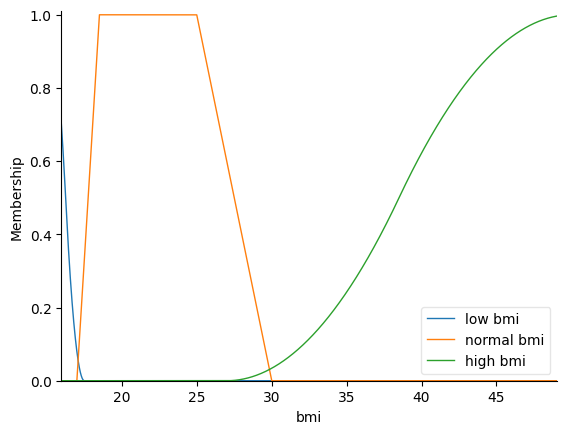

c:\ulstu\3.1\mii\AIM-PIbd-31-Barsukov-P-O\aimenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


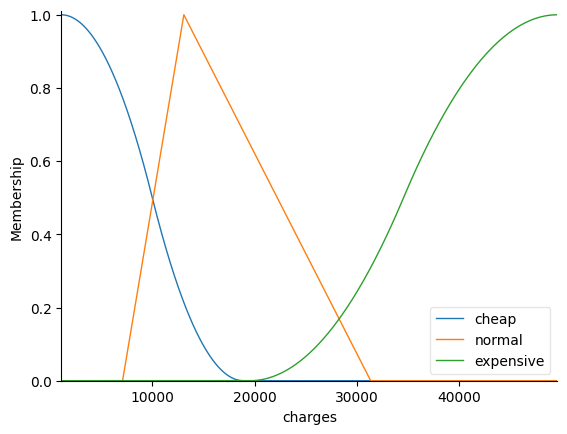

In [40]:
age_ctrl["young"] = fuzz.zmf(age_ctrl.universe, 17, 31)
age_ctrl["middle-aged"] = fuzz.trapmf(age_ctrl.universe, [29, 35, 45, 55])
age_ctrl["old"] = fuzz.smf(age_ctrl.universe, 50, 65)
age_ctrl.view()

bmi_ctrl["low bmi"] = fuzz.zmf(bmi_ctrl.universe, 15, 17.5)
bmi_ctrl["normal bmi"] = fuzz.trapmf(bmi_ctrl.universe, [17, 18.5, 25, 30])
bmi_ctrl["high bmi"] = fuzz.smf(bmi_ctrl.universe, 27, 50)
bmi_ctrl.view()

charge_min = df['charges'].min()
charge_max = df['charges'].max()
charge_mean = df['charges'].mean()
cheap_end = charge_min + (charge_mean - charge_min) * 0.5
expensive_start = charge_mean + (charge_max - charge_mean) * 0.5

std = df['charges'].std()
print(std)

charges_ctrl["cheap"] = fuzz.zmf(charges_ctrl.universe, charge_min, cheap_end + std)
charges_ctrl["normal"] = fuzz.trimf(charges_ctrl.universe, [cheap_end, charge_mean, expensive_start])
charges_ctrl["expensive"] = fuzz.smf(charges_ctrl.universe, expensive_start - std, charge_max)
charges_ctrl.view()

Формировка базы нечетких правил

(<Figure size 640x480 with 1 Axes>, <Axes: >)

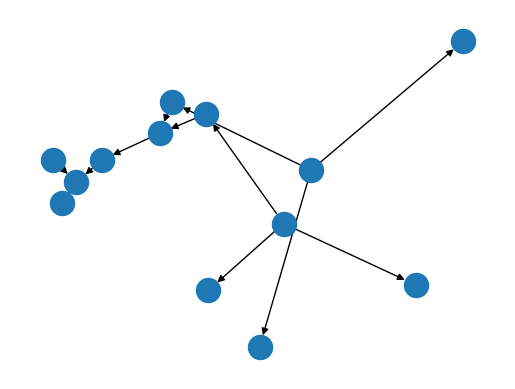

In [41]:
rule1 = ctrl.Rule(age_ctrl["young"] & bmi_ctrl["low bmi"], charges_ctrl["normal"])
rule2 = ctrl.Rule(age_ctrl["young"] & bmi_ctrl["normal bmi"], charges_ctrl["cheap"])
rule3 = ctrl.Rule(age_ctrl["young"] & bmi_ctrl["high bmi"], charges_ctrl["expensive"])
rule4 = ctrl.Rule(age_ctrl["middle-aged"] & bmi_ctrl["low bmi"], charges_ctrl["normal"])
rule5 = ctrl.Rule(age_ctrl["middle-aged"] & bmi_ctrl["normal bmi"], charges_ctrl["cheap"])
rule6 = ctrl.Rule(age_ctrl["middle-aged"] & bmi_ctrl["high bmi"], charges_ctrl["expensive"])
rule7 = ctrl.Rule(age_ctrl["old"] & bmi_ctrl["low bmi"], charges_ctrl["expensive"])
rule8 = ctrl.Rule(age_ctrl["old"] & bmi_ctrl["normal bmi"], charges_ctrl["normal"])
rule9 = ctrl.Rule(age_ctrl["old"] & bmi_ctrl["high bmi"], charges_ctrl["expensive"])

rule1.view()

In [42]:
charges_ctrl = ctrl.ControlSystem(
    [
        rule1,
        rule2,
        rule3,
        rule4,
        rule5,
        rule6,
        rule7,
        rule8,
        rule9,
    ]
)

charges = ctrl.ControlSystemSimulation(charges_ctrl)

Оценка качества

 Antecedents 
Antecedent: age                     = 18
  - young                           : 0.9897959183673469
  - middle-aged                     : 0.0
  - old                             : 0.0
Antecedent: bmi                     = 34.1
  - low bmi                         : 0.0
  - normal bmi                      : 0.0
  - high bmi                        : 0.1905860113421551

 Rules 
RULE #0:
  IF age[young] AND bmi[low bmi] THEN charges[normal]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - age[young]                                             : 0.9897959183673469
  - bmi[low bmi]                                           : 0.0
                               age[young] AND bmi[low bmi] = 0.0
  Activation (THEN-clause):
                                           charges[normal] : 0.0

RULE #1:
  IF age[young] AND bmi[normal bmi] THEN charges[cheap]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-

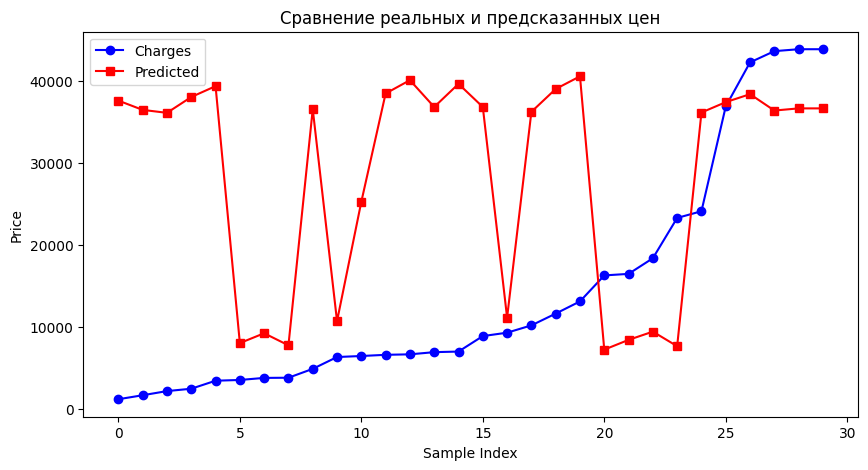

In [43]:
test_df = df[['age', 'bmi', 'charges']].sample(30, random_state=13)
test_df = test_df.reset_index(drop=True)

predicted = []

for i in range(len(test_df)):
    charges.input['age'] = test_df.loc[i, 'age']
    charges.input['bmi'] = test_df.loc[i, 'bmi']
    charges.compute()
    a = charges.print_state()
    predicted.append(charges.output['charges'])

test_df['Predicted'] = predicted
test_df_sorted = test_df.sort_values(by='charges')

print(test_df_sorted[['age', 'bmi', 'charges', 'Predicted']])

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df_sorted['charges'], marker='o', label='Charges', color='blue')
plt.plot(test_df.index, test_df_sorted['Predicted'], marker='s', label='Predicted', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.title("Сравнение реальных и предсказанных цен")
plt.show()


Как и ожидалось, модель ничего нормально не предсказала. Вероятно это из-за выбора неправильных параметров или недостаточноего числа параметров. Также вероятно база заданных правил неточная, потому что лингвистическая переменная возраста формировалась исключистельно субъективно, а переменная стоимости страхования на основе минимума, максимума, среднего и среднеквадратичного отклонения.